# Les données et la problématique

D'abord, parlons du jeu de données que nous allons utiliser. C'est un dataset très célèbre, appelé MNIST. Il est constitué d'un ensemble de 70000 images 28x28 pixels en noir et blanc annotées du chiffre correspondant (entre 0 et 9). L'objectif de ce jeu de données était de permettre à un ordinateur d'apprendre à reconnaître des nombres manuscrits automatiquement (pour lire des chèques par exemple). Ce dataset utilise des données réelles qui ont déjà été pré-traitées pour être plus facilement utilisables par un algorithme.

Ci dessous un extrait du dataset.

![alternatvie text](https://user.oc-static.com/upload/2016/11/27/14802845466_download.png)

Notre objectif sera donc d'entraîner un modèle qui sera capable de reconnaître les chiffres écrits sur ce type d'images. Par chance, ce jeu de données est téléchargeable directement à partir d'une fonction scikit-learn (librairie python contenant entre autre des algo de machine learning préfaits). On peut donc directement obtenir ce dataset via un appel de fonction :

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

Le dataset peut prendre un certain temps à se charger, soyez patients.

In [2]:
# le dataset principal qui contient toutes les images
mnist.data.shape

(70000, 784)

In [3]:
# le vecteur d'annotation associé au dataset (nombre compris entre 0 et 9)
mnist.target.shape

(70000,)

L'objet  mnist contient deux entrées principales,  data  et  target

- **data** contient les images sous forme de tableaux de 28 x 28 = 784 couleurs de pixel en niveau de gris, c'est-à-dire que la couleur de chaque pixel est représentée par un nombre entre 0 et 16 qui représente si celle-ci est proche du noir ou pas (0 = blanc, 16 = noir). 

- **target** qui contient les annotations (de 1 à 9) correspondant à la valeur "lue" du chiffre.

## Echantilloner pour faciliter le travail

Le dataset est relativement petit mais, pour le modèle k-NN, il est déjà trop gros pour obtenir rapidement des résultats. On va donc effectuer un sampling et travailler sur seulement 5000 données :

In [10]:
import numpy as np
sample = np.random.randint(70000, size=5000)

In [11]:
data = mnist.data.loc[sample]
target = mnist.target.loc[sample]

## Séparez training/testing set

Une fois notre dataset chargé, nous allons séparer le jeu de données en training set et testing set.
Ici on a appelé les images d'exemple "X" et les annotations cibles "y" :

In [12]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size=0.8)

on va utiliser uniquement le training set pour entraîner notre modèle et on garde le testing set pour plus tard. On a mis la répartition classique 80/20 entre training et testing set.

## le Knn

On peut créer un premier classifieur 3-NN, c'est-à-dire qui prend en compte les 3 plus proches voisins pour la classification. Pour cela, on va utiliser l'implémentation de l'algorithme qui existe dans la librairie scikit-learn :

In [13]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)

KNeighborsClassifier(n_neighbors=3)

l'algorithme ici n'effectue aucune optimisation mais va juste sauvegarder toutes les données en mémoire. C'est sa manière d'apprendre en quelque sorte.

Testons à présent l’erreur de notre classifieur. La méthode  score  effectue exactement ça : tester les performances de prédiction d'un classifieur dans lequel on passe un jeu de données annoté — dans notre cas le jeu de données de test. Il renvoie ainsi le pourcentage de prédiction véridique trouvée par le classifieur.

In [14]:
error = 1 - knn.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.071000


**nb : La performance exacte de notre modèle dépend du jeu de sélection. N'hésitez pas à lancer plusieurs fois ce traitement en changeant les jeux de données d'apprentissage et de test pour vous en rendre compte.**

le k (nombre de voisins) est l'hyper-paramètre que l’on va chercher à optimiser pour minimiser l’erreur sur les données test.

## Optimisation du score sur les données test

Pour trouver le k optimal, on va simplement tester le modèle pour tous les k de 2 à 15, mesurer l’erreur test et afficher la performance en fonction de k :

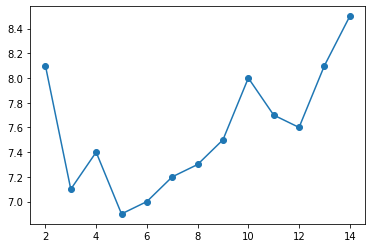

In [15]:
import matplotlib.pyplot as plt
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

Comme on peut le voir, le k-NN le plus performant est celui pour lequel k = 3. On connaît donc notre classifieur final optimal : 4-nn. Ce qui veut dire que c'est celui qui classifie le mieux les données, et qui donc dans ce cas précis reconnaît au mieux les nombres écrits à la main.

À titre d'exemple, vous pouvez afficher les prédictions du classifieur sur quelques données.

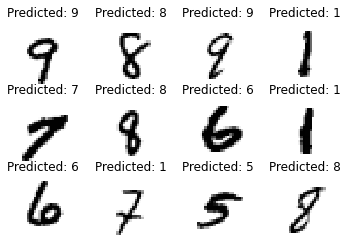

In [16]:
# On récupère le classifieur le plus performant
knn = neighbors.KNeighborsClassifier(3)
knn.fit(xtrain, ytrain)

# On récupère les prédictions sur les données test
predicted = knn.predict(xtest)

# On redimensionne les données sous forme d'images
images = xtest.values.reshape((-1, 28, 28))

# On selectionne un echantillon de 12 images au hasard
select = np.random.randint(images.shape[0], size=12)

# On affiche les images avec la prédiction associée
fig,ax = plt.subplots(3,4)

for index, value in enumerate(select):
    plt.subplot(3,4,index+1)
    plt.axis('off')
    plt.imshow(images[value],cmap=plt.cm.gray_r,interpolation="nearest")
    plt.title('Predicted: {}'.format( predicted[value]) )

plt.show()

Pour pouvoir un peu mieux comprendre les erreurs effectuées par le classifieur, on peut aussi afficher un extrait des prédictions erronées :

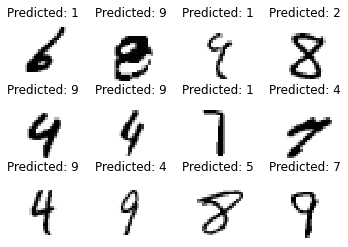

In [17]:
# on récupère les données mal prédites 
misclass = (ytest != predicted)
misclass_images = images[misclass,:,:]
misclass_predicted = predicted[misclass]

# on sélectionne un échantillon de ces images
select = np.random.randint(misclass_images.shape[0], size=12)

# on affiche les images et les prédictions (erronées) associées à ces images
for index, value in enumerate(select):
    plt.subplot(3,4,index+1)
    plt.axis('off')
    plt.imshow(misclass_images[value],cmap=plt.cm.gray_r,interpolation="nearest")
    plt.title('Predicted: {}'.format(misclass_predicted[value]) )

plt.show()

## En résumé

On vient de voir sur un algorithme simple comment l'entraîner sur des données pour ensuite optimiser les paramètres de cet algorithme à l’aide d’un jeu de données test.